In [1]:
# Add Project Root to PYTHONPATH
import sys; sys.path.append('../..')

from heatwave import GHCN, GHCNElement, Country
from heatwave import utils

import numpy as np
import pandas as pd

import netCDF4

from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.ndimage import binary_closing, binary_dilation

from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from datetime import date
import calendar
import os

import shapefile
from shapely import geometry

DATA_ROOT = os.path.abspath("../../data")

In [2]:
# Utils

def summer_indices(datetimeindex):
    summer_series = []
    for year in np.unique(datetimeindex.index.year):        
        if calendar.isleap(year):
            summer_series.append(datetimeindex.loc[f"23-06-{year}":f"21-08-{year}"])
        else:
            summer_series.append(datetimeindex.loc[f"24-06-{year}":f"22-08-{year}"])    
    return pd.concat(summer_series)

def plot_earth(view="EARTH"):
    # Create Big Figure
    plt.rcParams['figure.figsize'] = [25, 10]

    # create Projection and Map Elements
    projection = ccrs.PlateCarree()
    ax = plt.axes(projection=projection)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.STATES)
    ax.add_feature(cfeature.LAKES, color="white")
    ax.add_feature(cfeature.OCEAN, color="white")
    ax.add_feature(cfeature.LAND, color="lightgray")

    if view == "US":
        ax.set_xlim(-130, -65)
        ax.set_ylim(25, 50)
    elif view == "EAST US":
        ax.set_xlim(-105, -65)
        ax.set_ylim(25, 50)
    elif view == "EARTH":
        ax.set_xlim(-180, 180)
        ax.set_ylim(-90, 90)
    
    return projection

def plot_T95(T95, year):
    T95_std = T95.mean() + T95.std()

    # Create Big Figure
    plt.rcParams['figure.figsize'] = [15, 5]

    # Plot T95
    plt.title(f"Eastern US Heat Wave Events in Summer of {year}")
    plt.plot(T95[year], c="black", label="T95")
    plt.axhline(T95_std, c="gray", linestyle="--", label="T95 Mean + STD")
    plt.fill_between(T95[year].index, T95_std, T95[year], where=T95[year] > T95_std,
                     interpolate=True, color="crimson", label="Heat Wave Events")

    plt.ylabel("T95 (°C)")
    plt.xlabel("Date")
    plt.ylim(-2, 12)
    plt.legend()
    plt.show()
    
def strip_zeros(data):
    stripped_data = data.astype(np.float32)
    stripped_data[data == 0] = np.NaN
    return stripped_data

In [3]:
# Load ERA Data for Summer Days

TARGET = os.path.join(DATA_ROOT, "ERA/t2m_1979-2017_1_12_daily_0.75deg.nc")

t2m = netCDF4.Dataset(TARGET)
t2m_time = pd.DataFrame(index=pd.to_datetime(t2m['time'][:], unit='h', origin="1900-01-01"))
t2m_summer = summer_indices(t2m_time).index
t2m_data = t2m['t2m'][(t2m_summer - t2m_time.index[0]).days] - 273.15
t2m_lats = t2m['latitude'][:]
t2m_lons = t2m['longitude'][:]

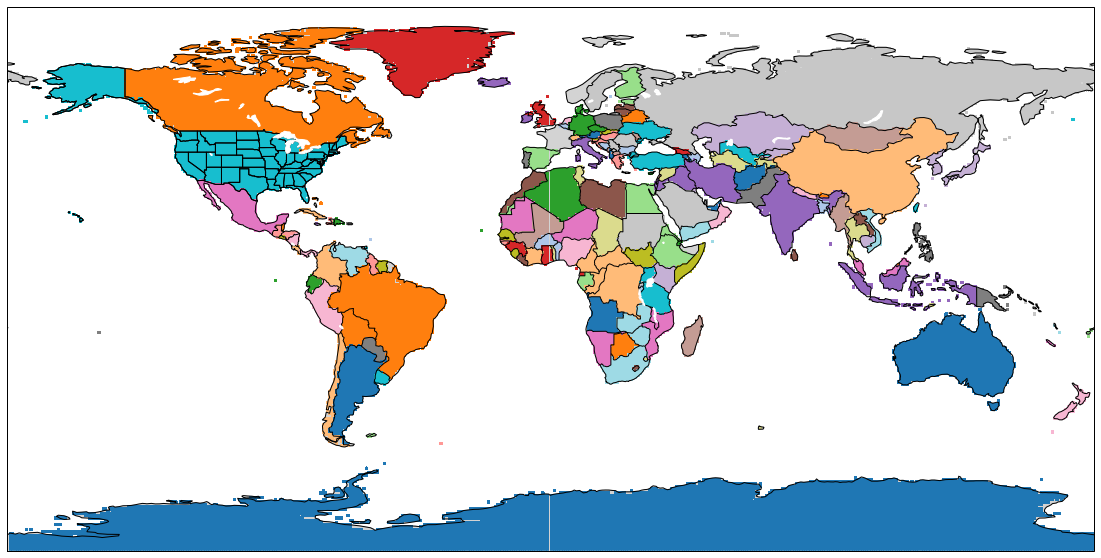

In [4]:
# Mask Per Country (To Get US)
countries_mask = utils.era_country_mask(TARGET)

countries_mask = countries_mask.astype(np.float)
countries_mask[countries_mask == -1] = np.NaN

plot_earth()
plt.pcolormesh(t2m_lons, t2m_lats, countries_mask, cmap="tab20")
plt.show()

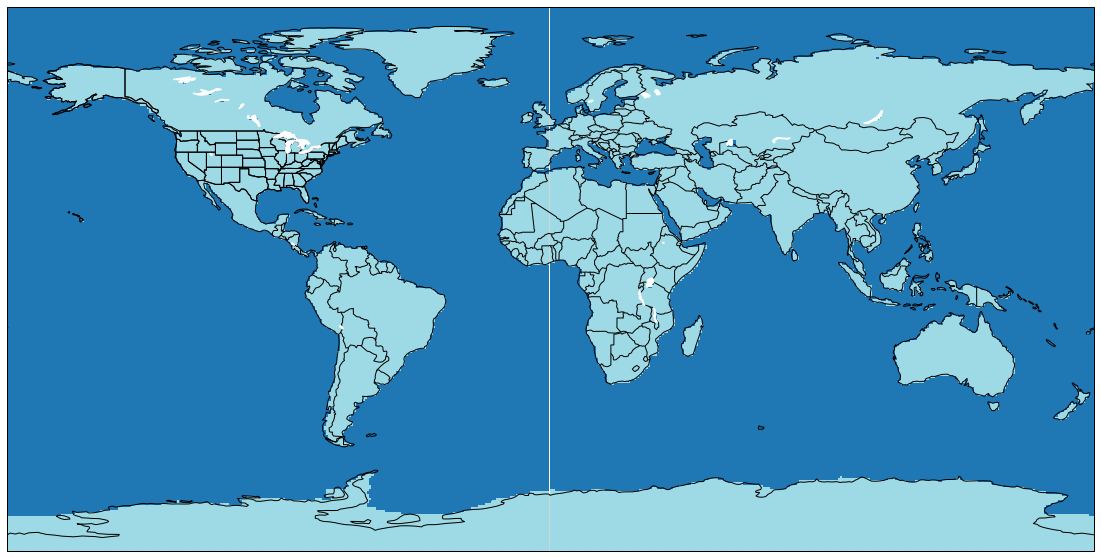

In [5]:
LSM  = netCDF4.Dataset(os.path.join(DATA_ROOT, "ERA/landseamask_0.75deg.nc"))
landseamask = LSM['lsm'][0].astype(np.bool)

plot_earth()
plt.pcolormesh(t2m_lons, t2m_lats, landseamask, cmap="tab20")
plt.show()

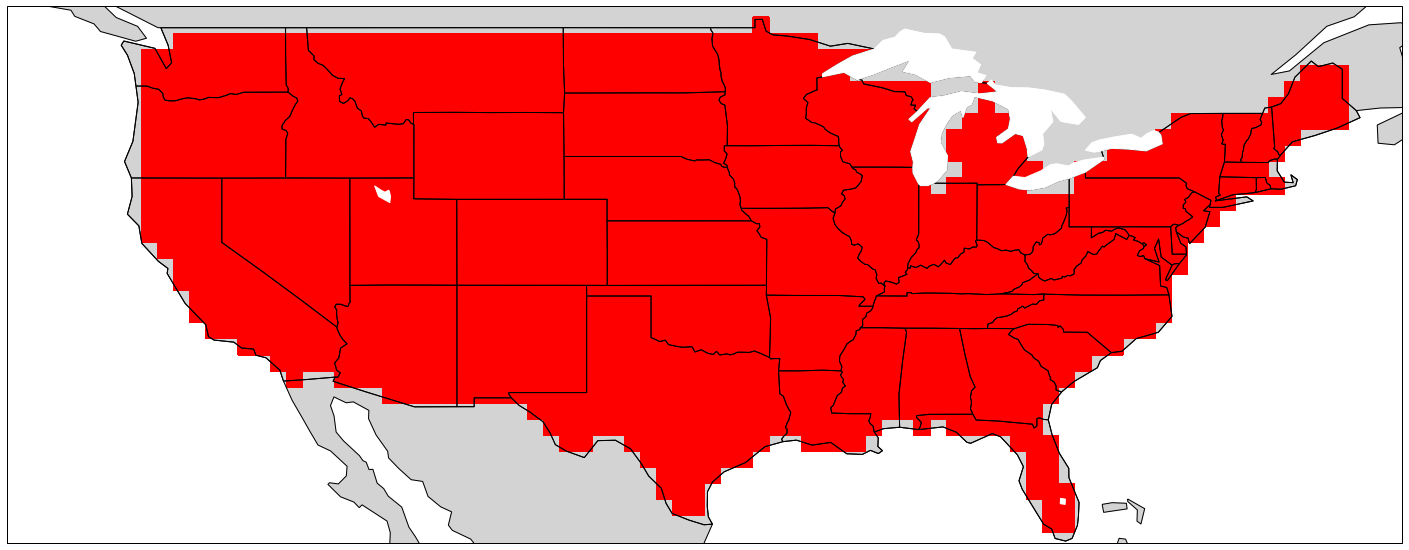

In [6]:
# Obtain (Buffered) Country Mask
mask = utils.era_country_mask(TARGET) == Country.US

# US Mainland Bounding Box Mask (To rule out Hawai & Alaska)
grid = utils.era_coordinate_grid(TARGET)
us_mainland_mask = (grid[..., 0] > 230) * (grid[..., 0] < 295) * (grid[..., 1] > 24) * (grid[..., 1] < 50)

# Obtain Final Mask (Binary closing for some nicer behaviour on inland waters)
mask_us = binary_closing(mask * us_mainland_mask)

mask_us *= landseamask

# Plot Mask in a suitable red color
mask_plot = mask_us.astype(np.float)
mask_plot[mask_us == False] = np.NaN
projection = plot_earth("US")
plt.pcolormesh(t2m_lons, t2m_lats, mask_plot, transform=projection, cmap="autumn")
plt.show()

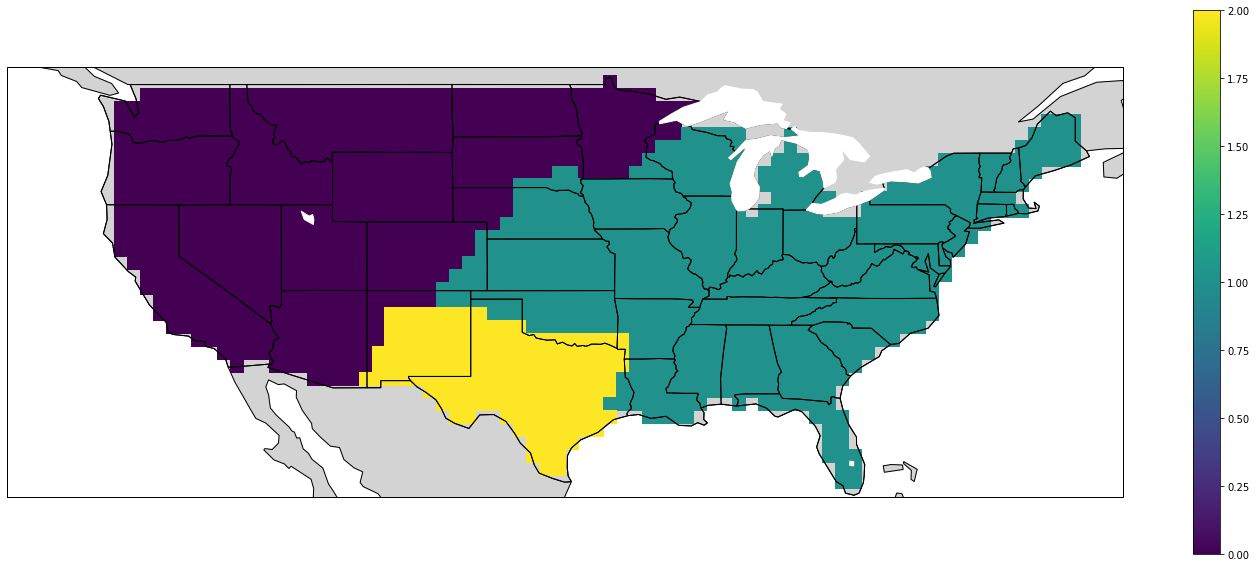

In [7]:
# Clustering

N = 3

t2m_us = t2m_data[:, mask_us]
T95_bool = t2m_us > np.quantile(t2m_us, 0.95, 0)

# cluster = KMeans(N)
# cluster = AgglomerativeClustering(N)
cluster = AgglomerativeClustering(N, affinity='jaccard', linkage='average')
cluster.fit(T95_bool.T)

labels = np.empty(t2m_data.shape[1:], np.float32)
labels.fill(np.NaN)
labels[mask_us] = cluster.labels_

label_coordinate = [np.mean(grid[labels == i], 0) for i in range(N)]
label_longitude = [coordinate[0] for coordinate in label_coordinate]
label_east = label_longitude.index(max(label_longitude))

# Plot Clustering
projection = plot_earth("US")
plt.pcolormesh(t2m_lons, t2m_lats, labels, transform=projection)
plt.colorbar()
plt.show()

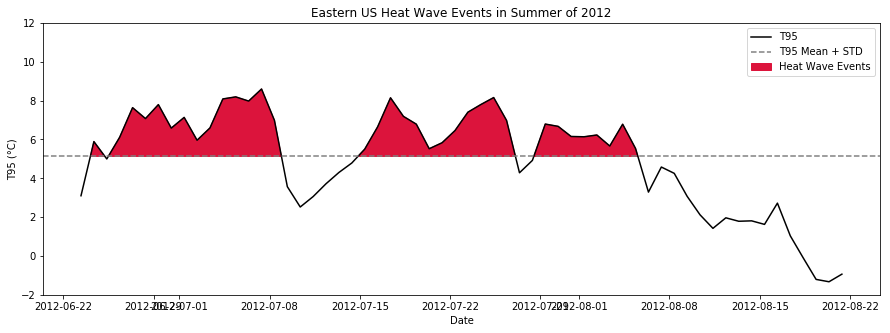

In [8]:
# Calculate & Plot T95

mask_east_us = labels == label_east

t2m_east_us = pd.DataFrame(t2m_data[:, mask_east_us], index=t2m_summer)
t2m_east_us_anomaly = t2m_east_us - t2m_east_us.mean()

T95 = t2m_east_us_anomaly.quantile(0.95, 1)

plot_T95(T95, "2012")

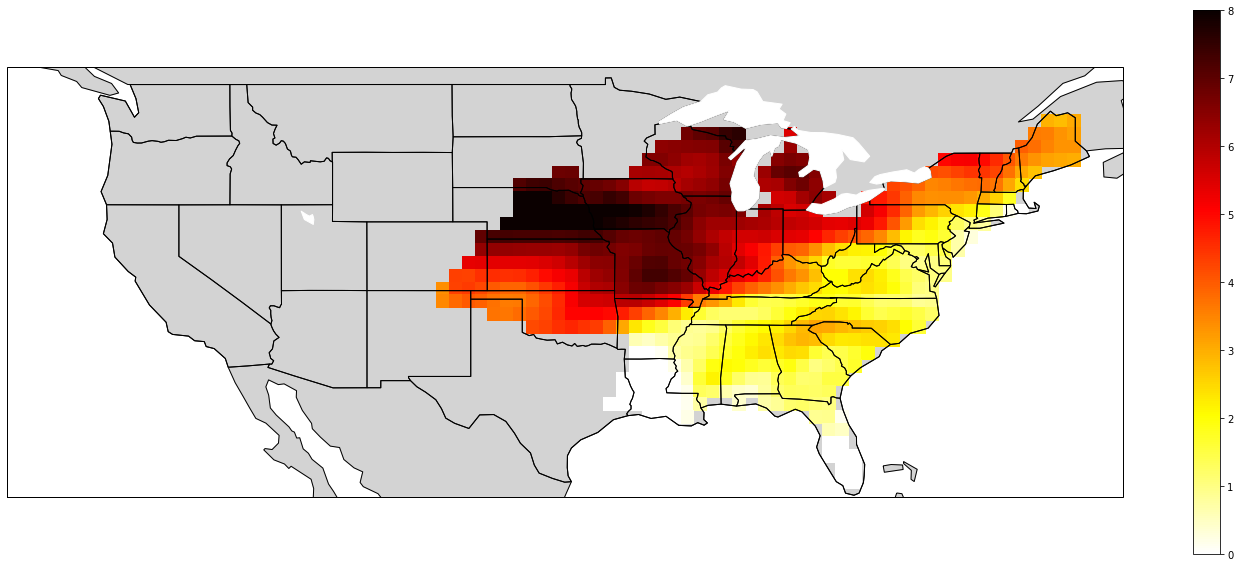

In [9]:
# Plot Temperature Anomalies on a specific hot summer day
t2m_east_anomaly_plot = np.empty(t2m_data.shape[1:], dtype=np.float32)
t2m_east_anomaly_plot.fill(np.NaN)
t2m_east_anomaly_plot[mask_east_us] = t2m_east_us_anomaly["2012-07-23"].values.ravel()

projection = plot_earth("US")
plt.pcolormesh(t2m_lons, t2m_lats, t2m_east_anomaly_plot, cmap="hot_r", transform=projection, vmin=0, vmax=8)
plt.colorbar()
plt.show()

# Create Pattern TimeSeries

In [12]:
# Load Precursor Regions

patterns = np.load(os.path.join(DATA_ROOT, 'sem/2019-01-21.npy'),  encoding='latin1').item()['ex']['score_per_run']
pattern_lag, pattern_longitude, pattern_latitude = patterns[0][3].lag.values, patterns[0][3].longitude.values, patterns[0][3].latitude.values
pattern_shape = (len(pattern_lag), len(pattern_latitude), len(pattern_longitude))

PATTERN_YEAR_INDEX = 0  # Arbitrary, Each Validation is just as valid as another
pattern = patterns[PATTERN_YEAR_INDEX][3]

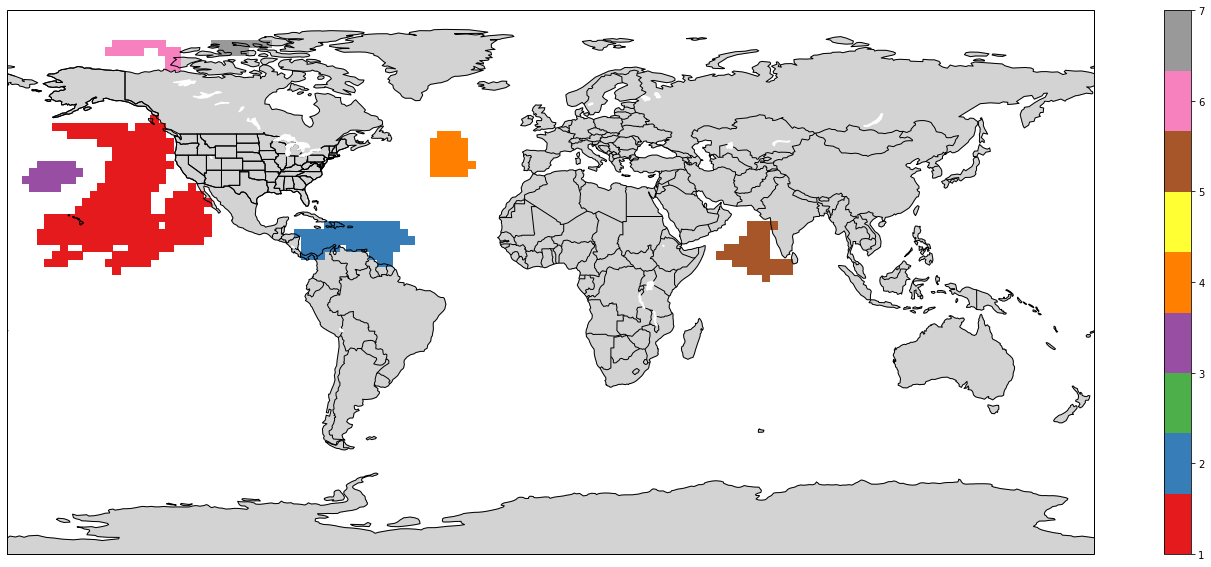

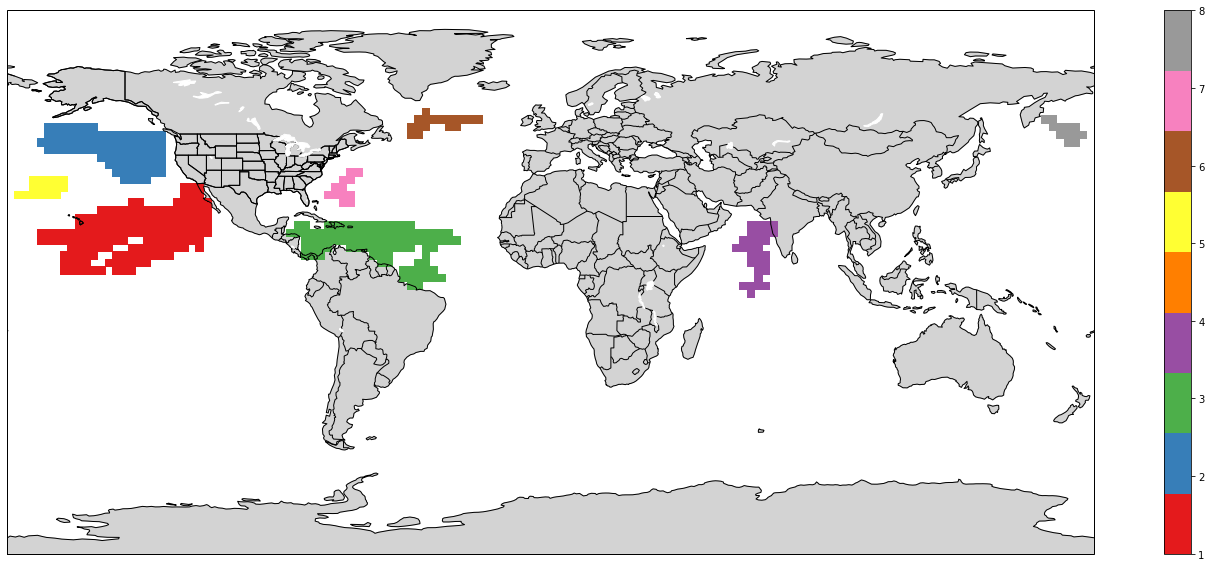

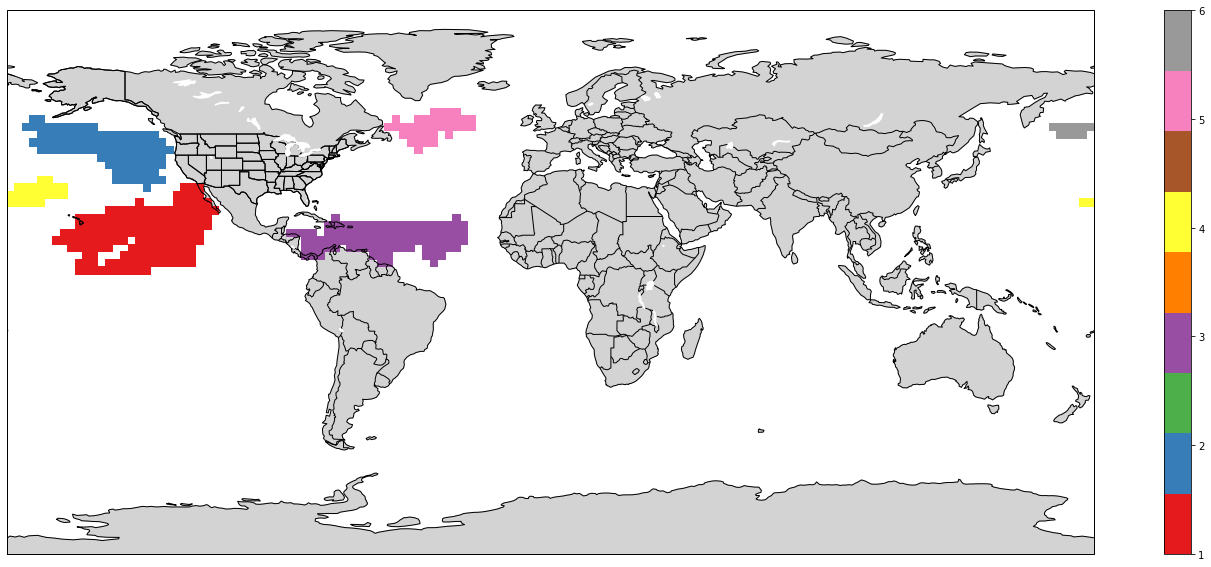

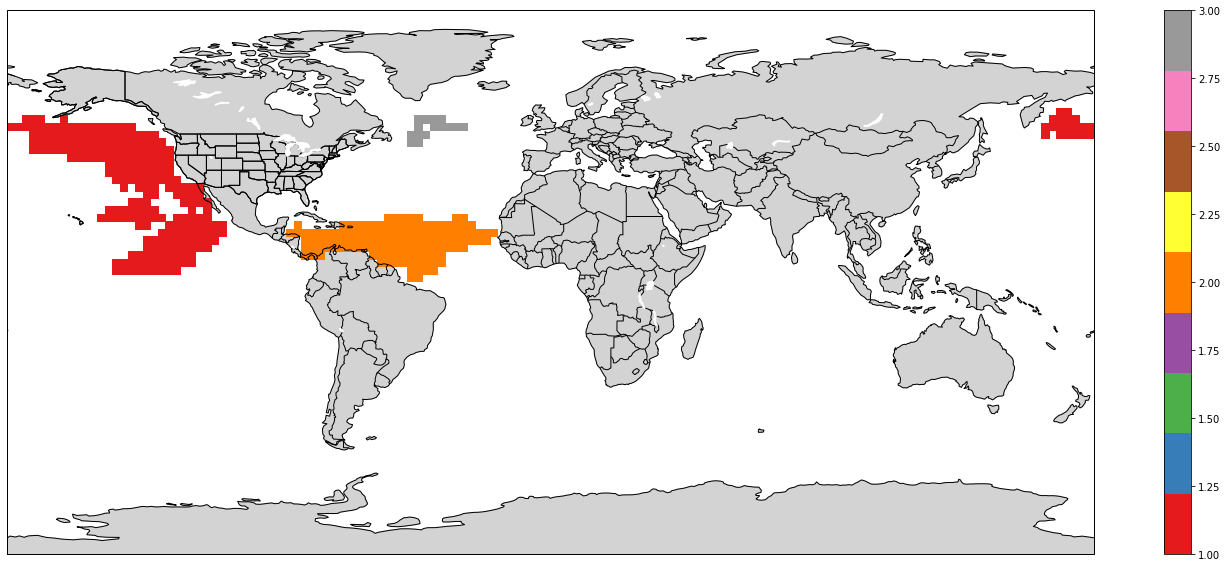

In [13]:
# Iterate over lags, with corresponding region indices and weights
for lag_idx, (lag, indices, weights) in enumerate([(l.values, i.values, w.values) for (l, i, w) in zip(pattern.lag, pattern.pattern_num, pattern.weights)]):
    unique_indices = np.unique(indices.ravel()[~np.isnan(indices.ravel())])[1:]
    
    plt.title("{} Precursor Regions at Lag {}".format(len(unique_indices), lag))
    plot_earth()
    plt.pcolormesh(pattern_longitude, pattern_latitude, strip_zeros(indices), transform=projection, cmap="Set1")
    plt.colorbar()
    plt.show()

In [14]:
# Load Sea Surface Temperatures (SST) & Calculate SST Anomalies (SST minus SST climatology = SST montly average)
# TODO: Is this method of calculating anomalies correct? A.k.a. is climatology monthly average temperature?

SST = netCDF4.Dataset(os.path.join(DATA_ROOT, 'ERA/sst_1979-2017_1_12_daily_2.5deg.nc'))
SST_longitude, SST_latitude = SST['longitude'][:].data, SST['latitude'][:].data

pattern_latitude_index = np.where(SST_latitude == pattern_latitude[0])[0][0]
SST_latitude = SST_latitude[pattern_latitude_index:pattern_latitude_index+len(pattern_latitude)]

SST_data = np.array(SST['sst'][:, pattern_latitude_index:pattern_latitude_index+len(pattern_latitude), :])
SST_time = pd.to_datetime(SST['time'][:], unit='h', origin="1900-01-01")

SST_df = pd.DataFrame(SST_data.reshape(len(SST['time']), -1), index=SST_time)
SST_anomaly = SST_df.groupby(SST_df.index.month).transform(lambda month: month - month.mean())
SST_anomaly = SST_anomaly.values.reshape(len(SST_df), len(SST_latitude), len(SST_longitude))

In [18]:
# Calculate Pattern Timeseries
# TODO: What to do with similar regions across lags? Aren't they in each others way?

pattern_df = pd.DataFrame(index=SST_time)
cos_weights = np.cos(np.deg2rad(SST_latitude))

# Iterate over lags, with corresponding region indices and weights
for lag_idx, (lag, indices, weights) in enumerate([(l.values, i.values, w.values) for (l, i, w) in zip(pattern.lag, pattern.pattern_num, pattern.weights)]):
    
    # Iterate over each region within a lag
    for region_idx in np.unique(indices.ravel()[~np.isnan(indices.ravel())])[1:]:
        region = indices == region_idx
        pattern_df['{}-{}'.format(lag, int(region_idx))] = np.average(SST_anomaly * weights * region, 1, cos_weights).mean(-1)   

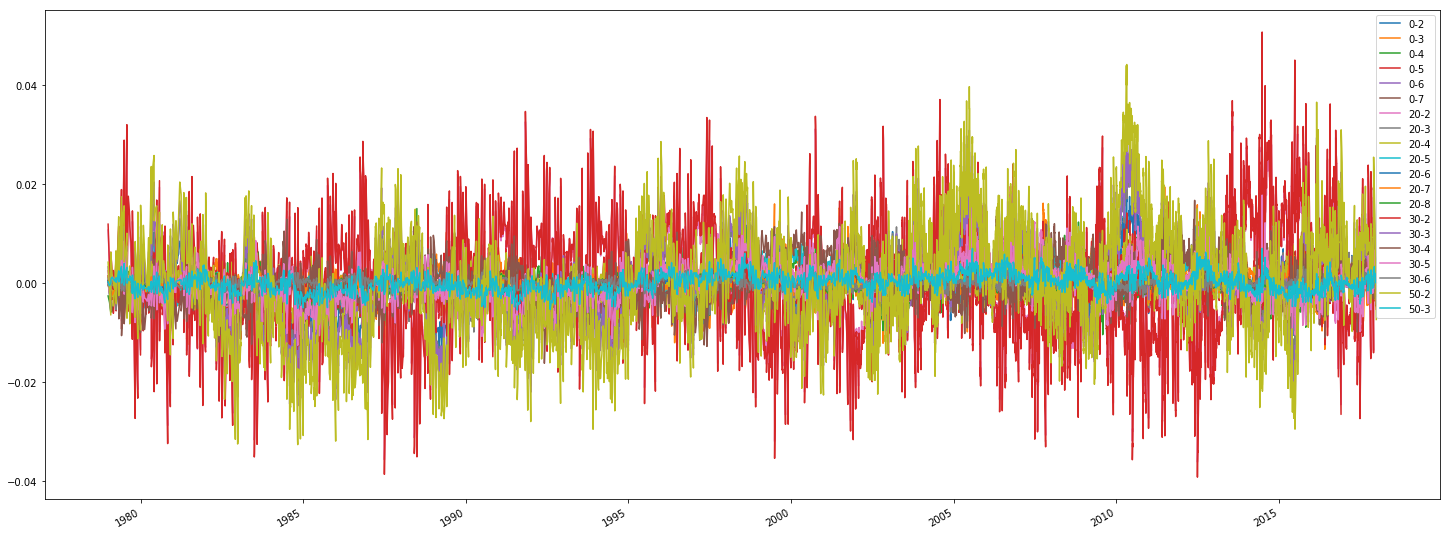

In [19]:
pattern_df.plot()